# 🥂 The Sales 

Have been really a long time since we haven't applied our ARIMA to the actual data. Yes we did in the **airline** passengers data but still here I will try to bring other stuff as well like making sense of it and checking the ***PACF***, ***ACF*** and ***Dciky-Fuller*** test by ourselves.

Let's see how.

In [1]:
# ususal imports
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 10)

# the modelling imports
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm


# to check error
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error

# to supress warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# loading the data in
df = pd.read_csv("../data/perrin-freres-monthly-champagne.csv", index_col=0, 
                 parse_dates=True, names=["Sales"],
                 skiprows=1)
df.head()

,Sales
1964-01,2815.0
1964-02,2672.0
1964-03,2755.0
1964-04,2721.0
1964-05,2946.0


In [3]:
df.tail()

,Sales
1972-07,4298.0
1972-08,1413.0
1972-09,5877.0
NaN,NaN
Perrin Freres monthly champagne sales millions ?64-?72,NaN


In [4]:
df = df["Sales"]

Since we are having the NaN values in the last 2 rows, we will drop them. 

In [5]:
# checking the number of NaN values
df.isna().sum()

2

In [6]:
df.dropna(inplace=True)

In [7]:
# again checking the NaN values
df.isna().sum()

0

Good 👍

In [8]:
df.shape

(105,)

Now, we are left with only `105` rows in the data and the data frequency is **monthly**; so let's just set that up as well.

In [9]:
# since the `parse=True` didn't work well, we will make the datetime out of it
df.index = pd.to_datetime(df.index, format="%Y-%m")

In [10]:
df.index.freq = "MS"

Good 👍

In [11]:
# splitting into training and testin
train_idx = df.iloc[:-12].index
test_idx = df.iloc[-12:].index

And **finally** now let's see how the data looks like!

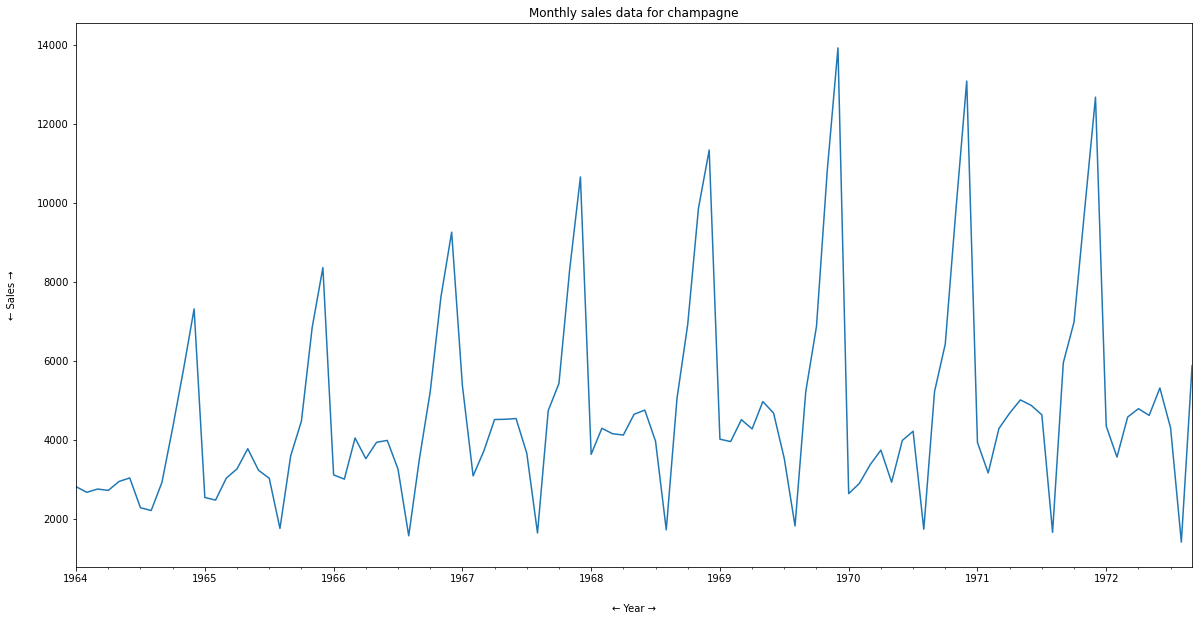

In [12]:
df.plot()
plt.title("Monthly sales data for champagne")
plt.xlabel("← Year →", labelpad=20)
plt.ylabel("← Sales →", labelpad=20);

🕶 **Some initial observations**:
- It is pretty clear that there is the **seasonality** in the data.
- The sales of champagne **gets higher** when we are heading towards the end of the year.
- Like from **October** to **December** it gets continuously high *(maybe people are preparing for Christmas)*.
- And in July to **August** the sales dips to the **lowest** in the whole year.
- The data seems **stationary** by looking in the first sight, if not most of the part.
- It is not like the passengers' dataset where even if there were rises and dips (seasonality) there was also the ***trend*** in the data.
- We will conclude whether the data is stationary or not by looking at the test, but for now let's keep it that way.

## ACF Test

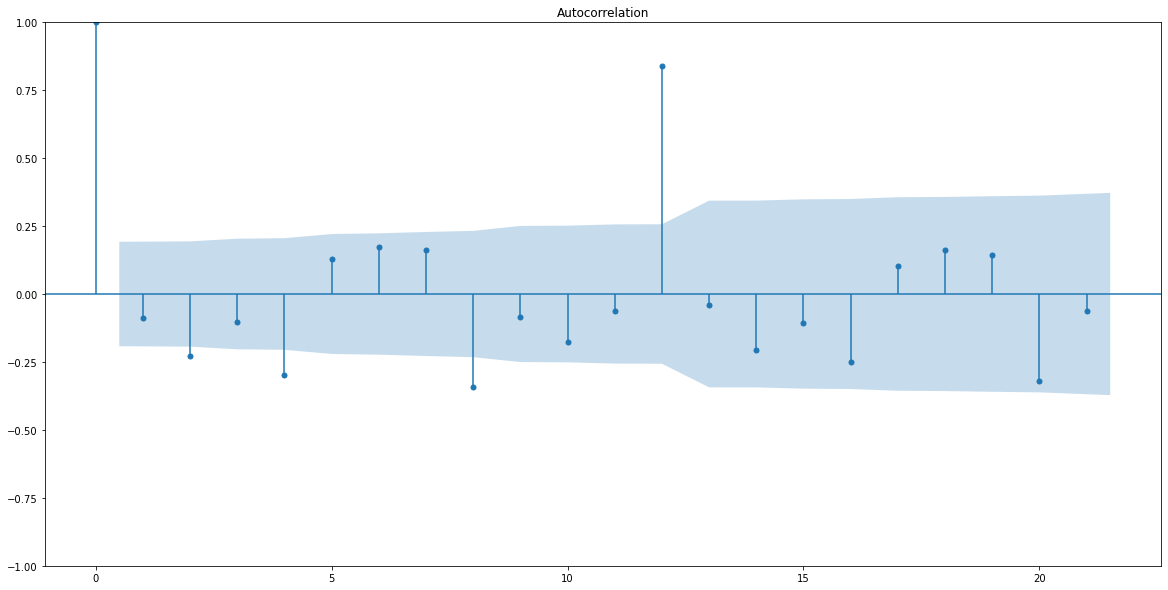

In [13]:
plot_acf(df.diff().dropna());

Oh my! We can set the `q` to **12**. And that is clear by this point. Let's see about `p`.

## PACF Test

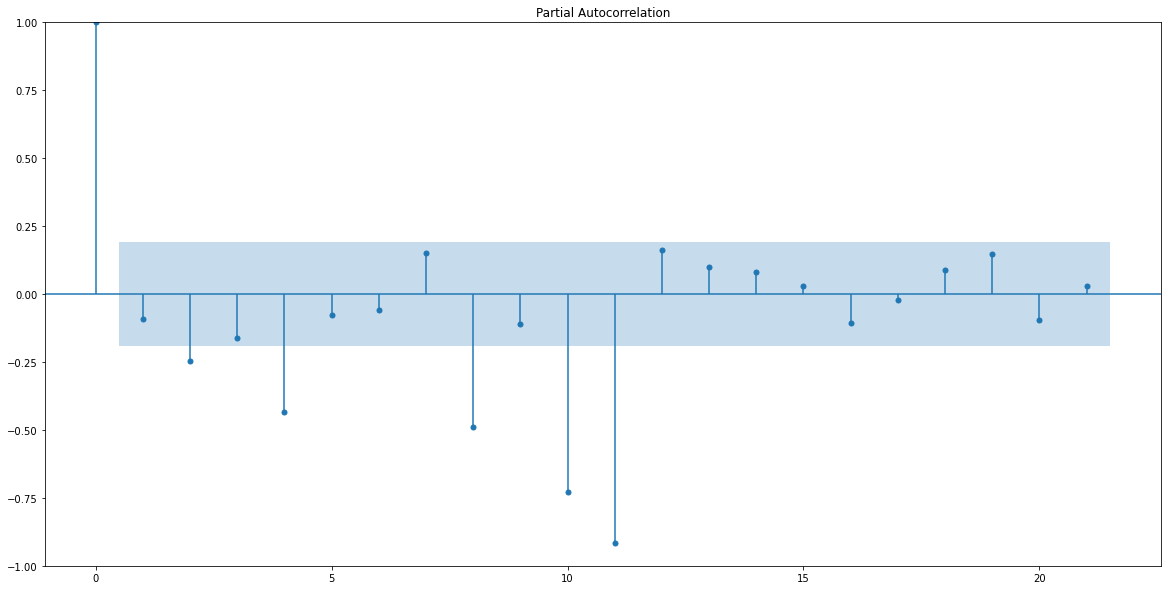

In [14]:
plot_pacf(df.diff().dropna(), method="ols");

It indicates that our data has highest dependency for the 11 points in the past. Strange that there is **only a little** spike on the 12th $\tau$. But we can choose between 11 and 12.

## Dicky Fuller Test

In [15]:
adfuller(df)

(-1.8335930563276237,
 0.3639157716602447,
 11,
 93,
 {'1%': -3.502704609582561,
  '5%': -2.8931578098779522,
  '10%': -2.583636712914788},
 1478.4633060594724)

Here we can see that the `p-value` is way higher than our critical threshold. It is `0.36391`. So, we can fail-to-reject the null hypothesis and say the time-series should be ***non-stationary***. So, we couldn't trust on our eyeballs 👏

In [16]:
adfuller(df.diff().dropna())

(-7.1898964480510115,
 2.5196204473869244e-10,
 11,
 92,
 {'1%': -3.503514579651927,
  '5%': -2.893507960466837,
  '10%': -2.583823615311909},
 1466.826726291589)

**Yep!!** Now, it is stationary, so we can work with it.

##### 

## Manual Modelling

In [17]:
# Creating the inital model accoring to our hypothesis
model = ARIMA(df[train_idx], order=(12, 1, 11))
result = model.fit()


insample_prediction = result.fittedvalues
forecast = result.get_forecast(12)
conf_interval = forecast.conf_int()
outsample_prediction = forecast.predicted_mean

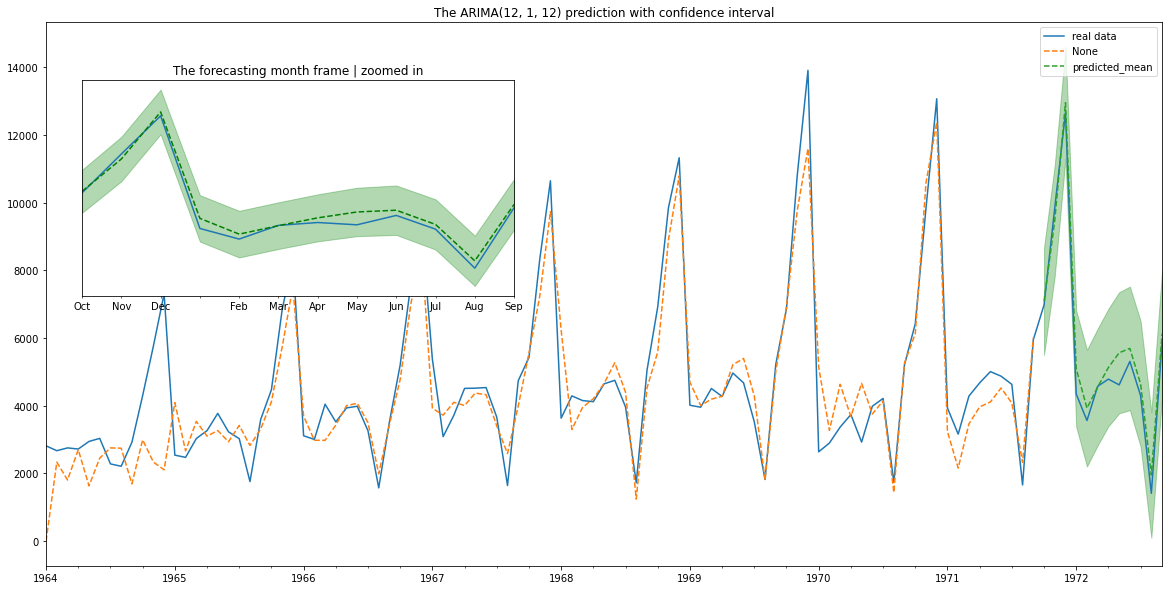

In [18]:
# the plotting code
main_axes = plt.axes()
small_axes = plt.axes([.15,.5,.3,.3])


df.plot(label="real data", ax=main_axes)
insample_prediction.plot(ax=main_axes, ls='dashed')
outsample_prediction.plot(ax=main_axes, ls='dashed')

main_axes.fill_between(outsample_prediction.index, 
                 conf_interval.iloc[:, 0],
                 conf_interval.iloc[:, 1],
                 alpha=0.3,
                 color="green")

df[test_idx].plot(ax=small_axes)
outsample_prediction.plot(ax=small_axes, ls='dashed', color="green")

small_axes.fill_between(outsample_prediction.index, 
                 conf_interval.iloc[:, 0],
                 conf_interval.iloc[:, 1],
                 alpha=0.3,
                 color="green")

small_axes.set(yticks=[], xticks=[], xlabel='',
               title="The forecasting month frame | zoomed in")

main_axes.legend()
main_axes.set_title("The ARIMA(12, 1, 12) prediction with confidence interval");

In [19]:
def print_error(true, pred):
    RMSE = mean_squared_error(true, pred, squared=False)
    R2 = r2_score(true, pred)
    MAPE = mean_absolute_percentage_error(true, pred)
    print("RMSE:", RMSE)
    print("MAPE:", round(MAPE * 100, 2), "%")
    print("R2:", R2)

In [20]:
print_error(df[test_idx], outsample_prediction)

RMSE: 462.5027391480802
MAPE: 10.1 %
R2: 0.9737082578315001


I think, this is our **base** result. We may want to tweak it a bit, for as we are ***practicing*** the auto_arima, we should stop here. And from now, let's see how the auto works.

## Auto Modelling

In [21]:
auto_model = pm.auto_arima(df[train_idx], 
                           seasonal=True,
                           trace=True,
                           m=12)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=1320.438, Time=1.49 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1315.739, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1313.732, Time=0.46 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1314.620, Time=0.48 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1325.791, Time=0.05 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1315.489, Time=0.07 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1314.184, Time=0.45 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1314.675, Time=1.04 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=1314.718, Time=0.20 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1315.563, Time=1.59 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1315.716, Time=0.31 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1315.762, Time=0.53 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=1315.796, Time=0.56 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=1313.652, Time=0.62 sec
 ARIMA(0,0,1)(0,1,0

We can observe that auto_arima always tries to find the **simplest** model. We made a **manual** model which dependent on past 12 values and past 12 errors.

Here, it has suggested a model which is based on:
- Past 1 error (just previous)
- Past 1 value (previous period)
- 1 Differencing 

In [22]:
def plot_and_print(model, title="", start=0):
    """
    This function is usable only for the PMDARIMA models.
    This will plot the appropriate plot and also will print
    the errors.
    """
    
    insample_prediction = model.predict_in_sample(start=start, end=-1)
    insample_prediction = pd.Series(insample_prediction, index=train_idx[start:])

    outsample_prediction, conf_interval = model.predict(12, return_conf_int=True)
    outsample_prediction = pd.Series(outsample_prediction, index=test_idx)

    # the plotting code
    main_axes = plt.axes()
    small_axes = plt.axes([.15,.5,.3,.3])


    df.plot(label="real data", ax=main_axes)
    insample_prediction.plot(ax=main_axes, ls='dashed')
    outsample_prediction.plot(ax=main_axes, ls='dashed')

    main_axes.fill_between(outsample_prediction.index, 
                     conf_interval[:, 0],
                     conf_interval[:, 1],
                     alpha=0.3,
                     color="green")

    df[test_idx].plot(ax=small_axes)
    outsample_prediction.plot(ax=small_axes, ls='dashed', color="green")

    small_axes.fill_between(outsample_prediction.index, 
                     conf_interval[:, 0],
                     conf_interval[:, 1],
                     alpha=0.3,
                     color="green")

    small_axes.set(yticks=[], xticks=[], xlabel='',
                   title="The forecasting month frame | zoomed in")

    main_axes.legend()
    if title:
        main_axes.set_title(title);
    else:
        params = model.get_params()
        order = str(params["order"])
        s_order = str(params["seasonal_order"])
        
        main_axes.set_title(f"The SARIMA {order}x{s_order} prediction with confidence interval");
        
    print_error(df[test_idx], outsample_prediction)

RMSE: 464.6912964871622
MAPE: 8.84 %
R2: 0.9734588447058274


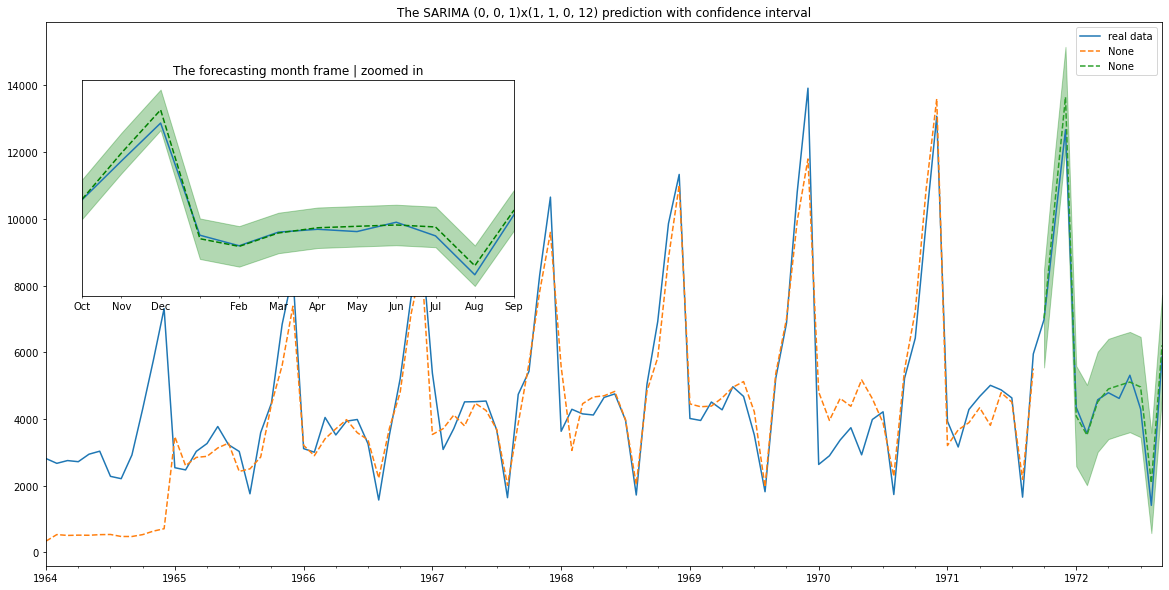

In [23]:
plot_and_print(auto_model)

> This model returns the similar result. But noticibly, the MAPE is lower than our manual model. Which is great because not only we get the simpler model, but also the more reliable model.

## Another try with auto, but without Seasonal

In [24]:
"""
Don't run this!!
"""
auto_model = pm.auto_arima(df[train_idx], 
                           seasonal=False,
                           trace=True,
                           stepwise=False,
                           max_d=1,
                           max_p=12,
                           max_q=12,
                           max_order=14, 
                           n_jobs=-1,
                           error_action="ignore")


Best model:  ARIMA(11,1,1)(0,0,0)[0] intercept
Total fit time: 60.753 seconds


RMSE: 420.6898164938583
MAPE: 9.24 %
R2: 0.9782472211310271


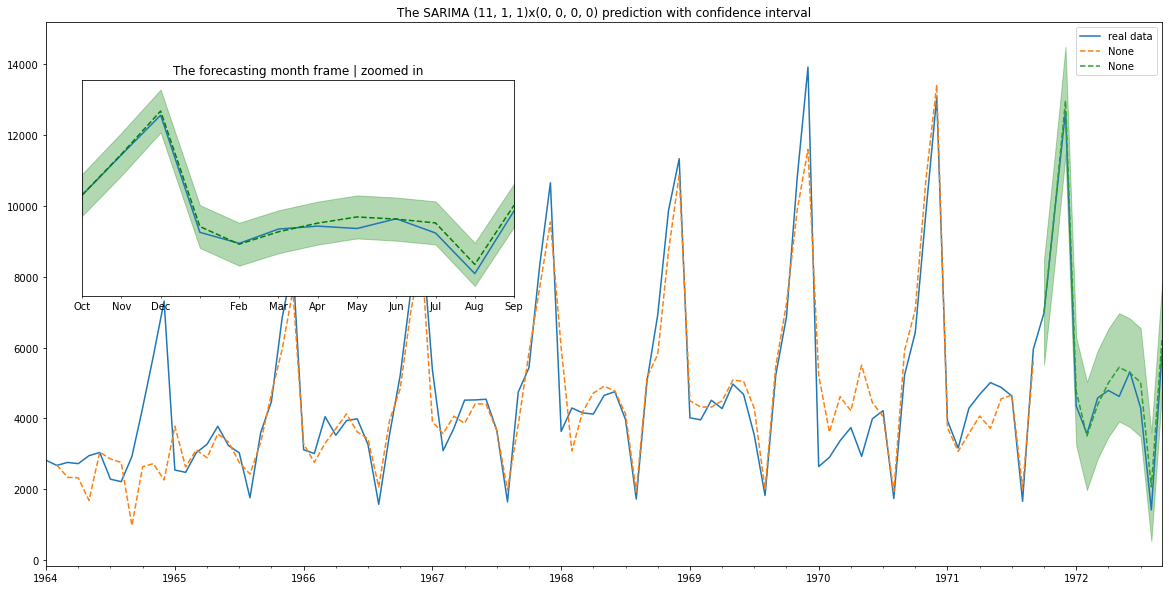

In [25]:
plot_and_print(auto_model, start=1)

See that, with this GridSearch — we are getting the **best** R2 till now. But the MAPE is a little increased. This models can be chosen but this is not the ***simplest*** model. 

# 

# Great!
We are finally done with this here. We could continue working on this by transforming this data into Log and other to get better results. But, I think we have driven the point home. 